In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

import community as community_louvain  # python-louvain
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
PROJECT_ROOT = Path.cwd().parents[0]
DATA_DIR = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "results"
FIG_DIR = RESULTS_DIR / "figures"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

train_edges = pd.read_csv(DATA_DIR / "train_edges.csv")
test_edges  = pd.read_csv(DATA_DIR / "test_edges.csv")
core_nodes  = set(map(int, (DATA_DIR / "core_nodes.txt").read_text().splitlines()))

print("Train edges:", len(train_edges))
print("Test edges:", len(test_edges))
print("Core nodes:", len(core_nodes))

Train edges: 20778
Test edges: 3867
Core nodes: 3942


In [3]:
G = nx.Graph()
G.add_edges_from(train_edges[["u", "v"]].itertuples(index=False, name=None))
G_core = G.subgraph(core_nodes).copy()

E_train = set(tuple(sorted(e)) for e in G_core.edges())
E_test  = set(tuple(sorted(e)) for e in test_edges[["u","v"]].itertuples(index=False, name=None))

print("G_core nodes:", G_core.number_of_nodes())
print("G_core edges:", G_core.number_of_edges())

G_core nodes: 3942
G_core edges: 10670


In [5]:
from collections import defaultdict

def generate_2hop_candidates(G, max_candidates=800_000, seed=42):
    rng = np.random.default_rng(seed)
    cand = set()
    nodes = list(G.nodes())
    rng.shuffle(nodes)

    for u in tqdm(nodes, desc="Generating 2-hop candidates"):
        neigh_u = set(G.neighbors(u))
        two_hop = set()
        for w in neigh_u:
            two_hop.update(G.neighbors(w))
        two_hop.discard(u)
        two_hop -= neigh_u

        for v in two_hop:
            a, b = (u, v) if u < v else (v, u)
            cand.add((a, b))
            if len(cand) >= max_candidates:
                return list(cand)
    return list(cand)

# Only run this if `scores` doesn't exist
if "scores" not in globals():
    candidates = generate_2hop_candidates(G_core, max_candidates=800_000, seed=42)
    candidates = [e for e in candidates if e not in E_train]

    deg = dict(G_core.degree())
    rows = []
    for (u, v) in tqdm(candidates, desc="Scoring candidates (CN/Jaccard/AA/PA)"):
        Nu = set(G_core.neighbors(u))
        Nv = set(G_core.neighbors(v))
        inter = Nu & Nv
        union = Nu | Nv

        cn = len(inter)
        jac = (len(inter) / len(union)) if len(union) else 0.0

        aa = 0.0
        for z in inter:
            kz = deg.get(z, 0)
            if kz > 1:
                aa += 1.0 / np.log(kz)

        pa = deg.get(u, 0) * deg.get(v, 0)

        rows.append((u, v, cn, jac, aa, pa))

    scores = pd.DataFrame(rows, columns=["u","v","CN","Jaccard","AA","PA"])
    print("Scores created:", scores.shape)

Scoring candidates (CN/Jaccard/AA/PA): 100%|██████████| 63841/63841 [00:01<00:00, 46016.91it/s]


Scores created: (63841, 6)


In [6]:
scores.to_csv(RESULTS_DIR / "lp_candidate_scores.csv", index=False)
print("Saved candidate scores.")

Saved candidate scores.


In [7]:
# Louvain partition: dict node -> community_id
partition = community_louvain.best_partition(G_core, random_state=42)
n_comms = len(set(partition.values()))

# Modularity Q (Lecture 4)
Q_louvain = community_louvain.modularity(partition, G_core)

print(f"Louvain communities: {n_comms}")
print(f"Louvain modularity Q: {Q_louvain:.4f}")

Louvain communities: 296
Louvain modularity Q: 0.7223


In [8]:
from collections import Counter
comm_sizes = Counter(partition.values())

sizes = np.array(sorted(comm_sizes.values(), reverse=True))
print("Top 10 community sizes:", sizes[:10])

Top 10 community sizes: [440 322 172 152 151 151 145 144 144 137]


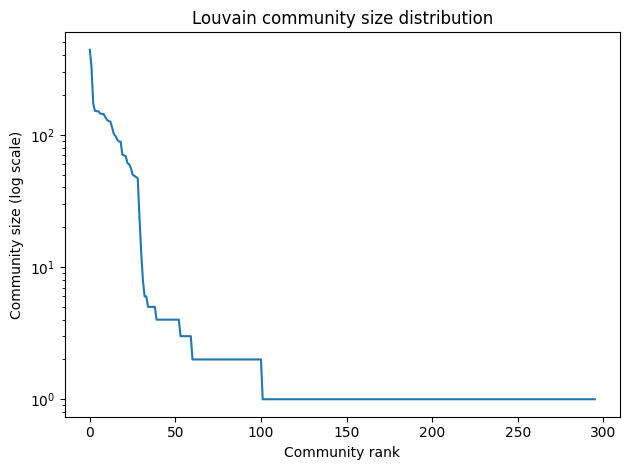

In [9]:
plt.figure()
plt.plot(sizes)
plt.yscale("log")
plt.xlabel("Community rank")
plt.ylabel("Community size (log scale)")
plt.title("Louvain community size distribution")
plt.tight_layout()
plt.savefig(FIG_DIR / "louvain_community_sizes_rankplot.png", dpi=250)
plt.show()

In [10]:
node_to_comm = partition
comm_to_size = dict(comm_sizes)

def add_community_features(scores_df):
    df = scores_df.copy()

    comm_u = []
    comm_v = []
    same = []
    cmin = []
    cmax = []
    csum = []

    for u, v in tqdm(df[["u","v"]].itertuples(index=False, name=None), total=len(df), desc="Adding community features"):
        cu = node_to_comm.get(u, -1)
        cv = node_to_comm.get(v, -1)
        su = comm_to_size.get(cu, 0)
        sv = comm_to_size.get(cv, 0)

        comm_u.append(cu)
        comm_v.append(cv)
        same.append(1 if cu == cv else 0)
        cmin.append(min(su, sv))
        cmax.append(max(su, sv))
        csum.append(su + sv)

    df["comm_u"] = comm_u
    df["comm_v"] = comm_v
    df["same_comm"] = same
    df["comm_size_min"] = cmin
    df["comm_size_max"] = cmax
    df["comm_size_sum"] = csum
    return df

scores_c = add_community_features(scores)
scores_c.head()

Adding community features: 100%|██████████| 63841/63841 [00:00<00:00, 178438.50it/s]


,u,v,CN,Jaccard,AA,PA,comm_u,comm_v,same_comm,comm_size_min,comm_size_max,comm_size_sum
0,14103,39176,1,0.111111,0.455120,16,7,7,1,145,145,290
1,14975,45521,1,0.090909,0.296974,32,52,6,0,71,440,511
2,16619,26304,1,0.043478,0.360674,144,7,25,0,102,145,247
3,42304,50878,1,0.071429,0.389871,56,38,38,1,144,144,288
4,12561,35480,1,0.055556,0.306928,90,1,1,1,322,322,644


In [11]:
# Candidate set and coverage
cand_set = set((min(u,v), max(u,v)) for u,v in zip(scores_c["u"], scores_c["v"]))
coverage = sum(1 for e in E_test if e in cand_set) / len(E_test)

n_new = len(E_test)
core_size = G_core.number_of_nodes()
m_old = len(E_train)
random_prob = n_new / ((core_size * (core_size - 1) // 2) - m_old)

print(f"Candidate coverage: {coverage:.4f}")
print(f"Random baseline prob: {random_prob:.8f}")

Candidate coverage: 0.7342
Random baseline prob: 0.00049851


In [12]:
# Label whether candidate is a true future edge
scores_c["label"] = [
    1 if (min(u,v), max(u,v)) in E_test else 0
    for u, v in scores_c[["u","v"]].itertuples(index=False, name=None)
]

print(scores_c["label"].value_counts(normalize=True))

label
0    0.95553
1    0.04447
Name: proportion, dtype: float64


In [13]:
def topn_accuracy(scores_df, score_col, E_test, n_new, ascending=False):
    df = scores_df.sort_values(score_col, ascending=ascending)
    top = list(zip(df["u"].values[:n_new], df["v"].values[:n_new]))
    correct = sum(1 for e in top if (min(e), max(e)) in E_test)
    return correct / n_new, correct

In [14]:
# same_comm as score (1 > 0)
acc_sc, correct_sc = topn_accuracy(scores_c, "same_comm", E_test, n_new, ascending=False)
print("same_comm top-n accuracy:", acc_sc, "correct:", correct_sc)

same_comm top-n accuracy: 0.07499353504008276 correct: 290


In [15]:
# Standardize AA for stable combination
aa_mean = scores_c["AA"].mean()
aa_std = scores_c["AA"].std() if scores_c["AA"].std() > 0 else 1.0
scores_c["AA_z"] = (scores_c["AA"] - aa_mean) / aa_std

for lam in [0.25, 0.5, 1.0, 2.0]:
    col = f"AA_plus_{lam}_same"
    scores_c[col] = scores_c["AA_z"] + lam * scores_c["same_comm"]

combo_cols = ["AA"] + [f"AA_plus_{lam}_same" for lam in [0.25, 0.5, 1.0, 2.0]]

combo_results = []
for col in combo_cols:
    acc, correct = topn_accuracy(scores_c, col, E_test, n_new, ascending=False)
    combo_results.append((col, acc, correct))

combo_df = pd.DataFrame(combo_results, columns=["Method", "Top-n accuracy", "Correct in top-n"])
combo_df["Improvement_vs_Random"] = combo_df["Top-n accuracy"] / random_prob
combo_df["Normalized_over_Coverage"] = combo_df["Top-n accuracy"] / coverage
combo_df.sort_values("Top-n accuracy", ascending=False)

,Method,Top-n accuracy,Correct in top-n,Improvement_vs_Random,Normalized_over_Coverage
1,AA_plus_0.25_same,0.361779,1399,725.713926,0.492779
2,AA_plus_0.5_same,0.360745,1395,723.638976,0.491370
0,AA,0.357642,1383,717.414125,0.487143
3,AA_plus_1.0_same,0.356607,1379,715.339174,0.485734
4,AA_plus_2.0_same,0.349366,1351,700.814521,0.475872


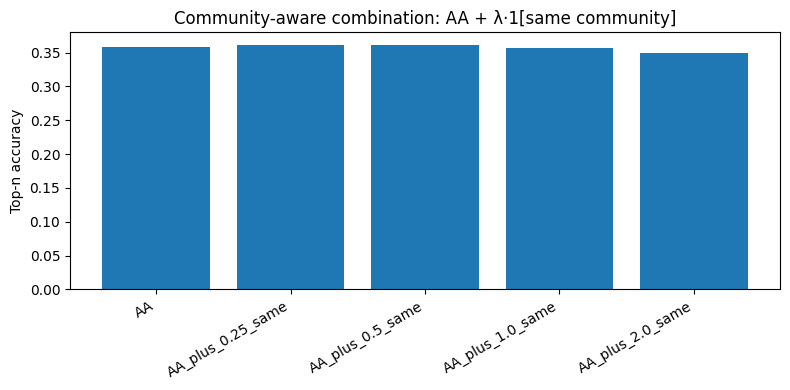

In [16]:
plt.figure(figsize=(8,4))
plt.bar(combo_df["Method"], combo_df["Top-n accuracy"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Top-n accuracy")
plt.title("Community-aware combination: AA + λ·1[same community]")
plt.tight_layout()
plt.savefig(FIG_DIR / "aa_samecommunity_combo_topn.png", dpi=250)
plt.show()